In [1]:
cd ~/data/modl_data/pipeline/contrast/prediction/1

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/1


In [2]:
ls

_artifacts/  config.json  cout.txt  info.json  prediction.csv  run.json


In [3]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [4]:
%matplotlib inline

def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [5]:
cd _artifacts

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/1/_artifacts


In [6]:
from modl.fixes import OurModel
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

Using TensorFlow backend.


Pipeline(memory=Memory(cachedir='/home/parietal/amensch/cache/joblib'),
     steps=[('classifier', LogisticRegression(C=4.761904761904762, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=24, penalty='l2',
          random_state=890565552, solver='saga', tol=1e-07, verbose=2,
          warm_start=False))])

In [ ]:
estimator.named_steps['classifier']

In [ ]:
model = estimator.steps[-1][1].stacked_model_

supervised_layers =  model.layers_by_depth[2]
embedding_layer =  model.layers_by_depth[3][0]

w0 = []
for layer in supervised_layers:
    this_w0, this_b0 = layer.get_weights()
    w0.append(this_w0)
w0 = np.concatenate(w0, axis=1)
w1 = embedding_layer.get_weights()[0]

coef = w1.dot(w0).T

In [ ]:
print('Sparsity', (coef == 0).sum() / coef.size)

In [8]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [9]:
len(prediction.loc['train'])

1890

In [10]:
prediction.loc['train', 'match']

dataset  subject  task       contrast              direction
archi    1        emotional  expression_control    level1        True
                             expression_intention  level1        True
                             expression_sex        level1        True
                             face_control          level1        True
                             face_sex              level1        True
                             face_trusty           level1        True
                  localizer  audio                 level1        True
                             calculaudio           level1        True
                             calculvideo           level1        True
                             clicDaudio            level1        True
                             clicDvideo            level1        True
                             clicGaudio            level1        True
                             clicGvideo            level1        True
                             

In [11]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

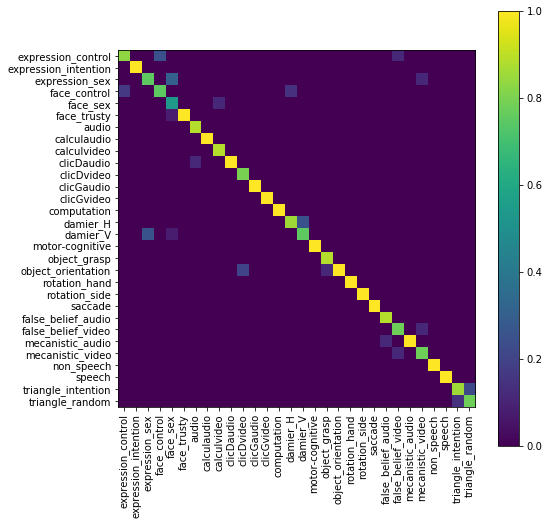

In [14]:
plot_confusion_matrix(test_conf, labels)

In [15]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task       contrast            
archi    emotional  expression_control      0.625
                    expression_intention    1.000
                    expression_sex          0.375
                    face_control            0.750
                    face_sex                0.875
                    face_trusty             0.875
         localizer  audio                   1.000
                    calculaudio             1.000
                    calculvideo             1.000
                    clicDaudio              0.875
                    clicDvideo              1.000
                    clicGaudio              1.000
                    clicGvideo              1.000
                    computation             1.000
                    damier_H                0.750
                    damier_V                0.750
                    motor-cognitive         1.000
         parietal   object_grasp            1.000
                    object_orientation      0.625
         

In [21]:
idx = pd.IndexSlice
prediction.loc[idx['test']]

predicted_label  \
dataset subject task      contrast             direction                         
archi   2       emotional expression_control   level1             face_control   
                          expression_intention level1     expression_intention   
                          expression_sex       level1         mecanistic_video   
                          face_control         level1             face_control   
                          face_sex             level1              calculvideo   
                          face_trusty          level1              face_trusty   
                localizer audio                level1                    audio   
                          calculaudio          level1              calculaudio   
                          calculvideo          level1              calculvideo   
                          clicDaudio           level1               clicDaudio   
                          clicDvideo           level1               clicDvideo   
                          clicGaudio           level1               clicGaudio   
                          clicGvideo           level1               clicGvideo   
                          computation          level1              computation   
                          damier_H             level1                 damier_V   
                          damier_V             level1                 damier_V   
                          motor-cognitive      level1          motor-cognitive   
                parietal  object_grasp         level1             object_grasp   
                          object_orientation   level1               clicDvideo   
                          rotation_hand        level1            rotation_hand   
                          rotation_side        level1            rotation_side   
                          saccade              level1                  saccade   
                social    false_belief_audio   level1       false_belief_audio   
                          false_belief_video   level1         mecanistic_video   
                          mecanistic_audio     level1         mecanistic_audio   
                          mecanistic_video     level1         mecanistic_video   
                          non_speech           level1               non_speech   
                          speech               level1                   speech   
                          triangle_intention   level1       triangle_intention   
                          triangle_random      level1          triangle_random   
...                                                                        ...   
        76      emotional expression_control   level1       expression_control   
                          expression_intention level1     expression_intention   
                          expression_sex       level1           expression_sex   
                          face_control         level1       expression_control   
                          face_sex             level1                 face_sex   
                          face_trusty          level1                 face_sex   
                localizer audio                level1                    audio   
                          calculaudio          level1              calculaudio   
                          calculvideo          level1              calculvideo   
                          clicDaudio           level1               clicDaudio   
                          clicDvideo           level1               clicDvideo   
                          clicGaudio           level1               clicGaudio   
                          clicGvideo           level1               clicGvideo   
                          computation          level1              computation   
                          damier_H             level1                 damier_H   
                          damier_V             level1                 damier_V   
                          motor-cognitive    

In [16]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.891667
train  archi      0.981481
val    archi      0.895238
Name: match, dtype: float64

In [ ]:
classifier = estimator.named_steps['classifier']

In [ ]:
histories = classifier.histories_

In [ ]:
history.epoch

In [ ]:
for history, n_samples in zip(histories, classifier.n_samples_):
    plt.plot(np.array(history.epoch) * n_samples, history.history['val_acc'])

In [ ]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [ ]:
np.mean(w0 == 0),np.mean(w1 == 0)

In [ ]:
np.histogram(w1)

In [ ]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)